In [27]:
import trimesh
import vedo
from scipy.optimize import minimize
import numpy as np
from scipy.spatial import KDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

from star.pytorch.star import STAR
from star.config import set_model_path
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def tmesh(mesh, c='grey', alpha=0.5):
    """convenience function for transparent mesh"""
    return vedo.Mesh(mesh, c=c, alpha=alpha)

## Load model

Set to A-pose and visualize joints.

In [29]:
set_model_path('star_1_1')
num_betas=20
batch_size=1
star = STAR(gender='male', num_betas=num_betas)
template_mesh = trimesh.Trimesh(star.v_template, star.f, process=False)

np.random.seed(42)
A_pose_np = np.zeros((batch_size, 72))
A_pose_np[:, 3*1+2] = 0.2
A_pose_np[:, 3*2+2] = -0.2
A_pose_np[:, 3*13+2] = -0.5
A_pose_np[:, 3*14+2] = 0.5
A_pose_np[:, 3*16+2] = -0.5
A_pose_np[:, 3*17+2] = 0.5
poses = torch.tensor(A_pose_np, requires_grad=True)
betas = torch.tensor(np.zeros((batch_size, num_betas)), requires_grad=True)
trans = torch.tensor(np.zeros((batch_size,3)), requires_grad=True)

output = star.forward(poses, betas, trans)
vertices = output[-1, :, :].detach().numpy()
# vertices = np.roll(vertices, 1, axis=1)

A_pose_template_mesh = trimesh.Trimesh(vertices, output.f, process=False)

vedo.show(vedo.Mesh(A_pose_template_mesh, c='grey', alpha=0.5), vedo.Spheres(output.J_transformed.detach()[0], r=0.03), 
          *(vedo.Text(i, p+(0, 0.05, 0), s=0.05) for i, p in enumerate(output.J_transformed.detach().numpy()[0])),
          axes=1, viewup='y')

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0367035736050695…

## Visualize head, hands vertices

These will be excluded in fitting

In [30]:
part_names = ['head', 'hand_left', 'hand_right', 'toes']
colors = ['red', 'blue', 'green', 'yellow']
with open('vertex_groups.json') as fin:
    vertex_groups = json.load(fin)
exc_verts = np.concatenate([vertex_groups[n] for n in part_names])
inc_verts = np.ones(template_mesh.vertices.shape[0], dtype=bool)
inc_verts[exc_verts] = False

vedo.show(
    *(vedo.Spheres(template_mesh.vertices[vertex_groups[n]], r=0.01, c=c) for c, n in zip(colors, part_names)),
    tmesh(template_mesh)
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0263062997804194…

## Load target mesh

In [17]:
target_mesh = trimesh.load_mesh('ORPH_20200122_2354_healed.obj')
target_mesh.vertices *= 0.001 # convert mm -> meter
target_mesh.vertices = np.roll(target_mesh.vertices, -1, axis=1) # convert z-up -> y-up

# align target mesh with template mesh using just centroid
target_mesh.vertices += -target_mesh.centroid + A_pose_template_mesh.centroid
target_mesh.vertices[:, 1] -= .1

In [18]:
# get target heels
v = target_mesh.vertices
mid_x = (v[:, 0].max()+v[:, 0].min())/2
left = v[v[:, 0] > mid_x]
left_heel = left[(left[:, 1]+left[:, 2]).argmin()]
right = v[v[:, 0] < mid_x]
right_heel = right[(right[:, 1]+right[:, 2]).argmin()]

In [19]:
vedo.show(vedo.Points(v), vedo.Sphere(left_heel, r=0.01), vedo.Sphere(right_heel, r=0.01))

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0149682248991288…

In [20]:
template_verts = A_pose_template_mesh.vertices[inc_verts]
dists, idxs = target_mesh.kdtree.query(template_verts)
arrows = vedo.Arrows(template_verts, target_mesh.vertices[idxs])
vedo.show(
    tmesh(A_pose_template_mesh),
    tmesh(target_mesh), 
    arrows
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0236406514563162…

In [21]:
def calc_loss(forwarded_v, exc_verts=[], min_comp_cosine=0, landmarks=[], E_weights=(1, 1)):
    E_data = data_loss(forwarded_v, target_mesh, exc_verts, min_comp_cosine)
    E_lm = landmark_loss(forwarded_v, landmarks)
    
    E_total = E_weights[0]*E_data + E_weights[1]*E_lm
    
    return E_total

def data_loss(deformed_v : torch.Tensor, target_mesh, exc_verts, min_comp_cosine):
    deformed_mesh = trimesh.Trimesh(deformed_v.detach().numpy(), star.f, process=False)
    dists, idxs = target_mesh.kdtree.query(deformed_mesh.vertices)
    deformed_normals = deformed_mesh.vertex_normals
    target_normals = target_mesh.vertex_normals
    incompatible = (target_normals[idxs]*deformed_normals).sum(axis=1) < min_comp_cosine
    weights = np.ones(template_mesh.vertices.shape[0])
    weights[incompatible] = 0
    weights[exc_verts] = 0

    dist_tensor = (((deformed_v-torch.tensor(target_mesh.vertices[idxs]))*torch.tensor(weights[:, None]))**2).sum() / weights.sum()
    return dist_tensor

def landmark_loss(deformed_v : torch.Tensor, landmarks):
    loss = torch.tensor(0.)
    for template_idx, target in landmarks:
        loss += ((deformed_v[template_idx] - torch.tensor(target))**2).sum()
    loss /= len(landmarks)
    return loss

In [22]:
# get target heels
v = A_pose_template_mesh.vertices
mid_x = (v[:, 0].max()+v[:, 0].min())/2
left_idx, = (v[:, 0] > mid_x).nonzero()
template_left_heel_idx = left_idx[(v[left_idx, 1]+v[left_idx, 2]).argmin()]
right_idx, = (v[:, 0] < mid_x).nonzero()
template_right_heel_idx = right_idx[(v[right_idx, 1]+v[right_idx, 2]).argmin()]

vedo.show(vedo.Points(v), vedo.Sphere(v[template_left_heel_idx], r=0.05), vedo.Sphere(v[template_right_heel_idx], r=0.05))


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0239303127896421…

In [23]:
landmarks = [(template_left_heel_idx, left_heel), (template_right_heel_idx, right_heel)]
def simple_loss(poses, betas, trans, min_comp_cosine=0, E_weights=(1, 1)):
    forwarded_v = star.forward(poses, betas, trans)[0]
    return calc_loss(forwarded_v, exc_verts, min_comp_cosine, landmarks, E_weights)

## Fit using naive gradient descent

In [24]:
# poses = torch.tensor(A_pose_np, dtype=torch.float, requires_grad=True)
# betas = torch.tensor(np.random.normal(0, 0, (batch_size, num_betas)), dtype=torch.float, requires_grad=True)
# trans = torch.tensor(np.ones((batch_size,3))*0, dtype=torch.float, requires_grad=True)

# alpha=1e-4
# iters = 500
# errors = []

# # phase 1: quickly fit everything
# for i in tqdm(range(200)):
#     dist_tensor = simple_loss(poses, betas, trans, min_comp_cosine=0)
#     dist_tensor.backward()
# #     poses_grad = poses.grad.detach().numpy()
# #     poses_grad[0, 0] = 0
#     with torch.no_grad():
#         poses.grad[0, 0] = 0
#         poses -= poses.grad*alpha*20
#         betas -= betas.grad*alpha*2000
#         trans -= trans.grad*alpha
#     poses.grad = None
#     betas.grad = None
#     trans.grad = None
#     errors.append(dist_tensor.detach().numpy())
# # phase 2: fit only shape parameters (betas)
# for i in tqdm(range(500)):
#     dist_tensor = simple_loss(poses, betas, trans, min_comp_cosine=0)
#     dist_tensor.backward()
# #     poses_grad = poses.grad.detach().numpy()
# #     poses_grad[0, 0] = 0
#     with torch.no_grad():
# #         poses.grad[0, 0] = 0
# #         poses -= poses.grad*alpha
#         betas -= betas.grad*alpha*1000
# #         trans -= trans.grad*alpha
#     poses.grad = None
#     betas.grad = None
#     trans.grad = None
#     errors.append(dist_tensor.detach().numpy())
# # phase 3: fit everything once more
# for i in tqdm(range(1000)):
#     dist_tensor = simple_loss(poses, betas, trans, min_comp_cosine=0.866) # limit to <30 degrees between normals
#     dist_tensor.backward()
# #     poses_grad = poses.grad.detach().numpy()
# #     poses_grad[0, 0] = 0
#     with torch.no_grad():
#         poses.grad[0, 0] = 0
#         poses -= poses.grad*alpha*10
#         betas -= betas.grad*alpha*1000
#         trans -= trans.grad*alpha
#     poses.grad = None
#     betas.grad = None
#     trans.grad = None
#     errors.append(dist_tensor.detach().numpy())
# new_v = star.forward(poses, betas, trans)[0]
# deformed_mesh = trimesh.Trimesh(new_v.detach().numpy(), star.f, process=False)
# vedo.show(
# #     tmesh(A_pose_template_mesh, c='magenta'),
#     tmesh(target_mesh, c='green'), 
#     tmesh(deformed_mesh, c='yellow')
# )

In [25]:
# plt.plot(errors)

## Fit using PyTorch's LBFGS

Determined to be the best method.

In [26]:
poses = torch.tensor(A_pose_np, dtype=torch.float, requires_grad=True)
betas = torch.tensor(np.random.normal(0, 0, (batch_size, num_betas)), dtype=torch.float, requires_grad=True)
trans = torch.tensor(np.ones((batch_size,3))*0, dtype=torch.float, requires_grad=True)

errors = []

from torch.optim import LBFGS

optimizer = LBFGS([poses, betas, trans], lr=1)

def constrain_poses(poses):
    with torch.no_grad():
        poses.grad[0, 2] = 0
        poses.grad[0, 3*12+1] = 0
        poses.grad[0, 3*12+2] = 0
        poses.grad[0, 3*15+1] = 0
        poses.grad[0, 3*15+2] = 0
        
def closure():
    optimizer.zero_grad()
    loss = simple_loss(poses, betas, trans, min_comp_cosine=0, E_weights=(10, 1))
    loss.backward()
    constrain_poses(poses)
    return loss
for i in tqdm(range(20)):
    loss = optimizer.step(closure)
    errors.append(loss.detach().numpy())
def closure2():
    optimizer.zero_grad()
    loss = simple_loss(poses, betas, trans, min_comp_cosine=0, E_weights=(10, 0))
    loss.backward()
    constrain_poses(poses)
    return loss
# for i in tqdm(range(20)):
#     loss = optimizer.step(closure2)
#     errors.append(loss.detach().numpy())
    
new_v = star.forward(poses, betas, trans)[0]
deformed_mesh = trimesh.Trimesh(new_v.detach().numpy(), star.f, process=False)
vedo.show(
#     tmesh(A_pose_template_mesh, c='magenta'),
    tmesh(target_mesh, c='green'), 
    tmesh(deformed_mesh, c='yellow')
)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


RuntimeError: expected scalar type Double but found Float

In [ ]:
plt.plot(errors[1:]) # skip first error as LBFGS works too well first iteration

## Fit using Stochastic Gradient Descent (SGD) module

I guess in this case, it's not really stochastic but just doing normal gradient descent? Just more efficiently using Pytorch's implementation?

In [17]:
# poses = torch.tensor(A_pose_np, dtype=torch.float, requires_grad=True)
# betas = torch.tensor(np.random.normal(0, 0, (batch_size, num_betas)), dtype=torch.float, requires_grad=True)
# trans = torch.tensor(np.ones((batch_size,3))*0, dtype=torch.float, requires_grad=True)

# errors = []

# from torch.optim import SGD

# optimizer = SGD([dict(params=poses, lr=1e-3), dict(params=betas, lr=1), dict(params=trans)], lr=1e-4)
# def closure():
#     optimizer.zero_grad()
#     loss = simple_loss(poses, betas, trans, 0, (2, 1))
#     loss.backward()
# #     with torch.no_grad():
# #         poses.grad[0, 0] = 0 # restrict global rotation to 0
#     return loss
# for i in tqdm(range(20)):
#     loss = optimizer.step(closure)
#     errors.append(loss.detach().numpy())
# for pg in optimizer.param_groups:
#     pg['lr'] /= 5
# for i in tqdm(range(1000)):
#     loss = optimizer.step(closure)
#     errors.append(loss.detach().numpy())
    
# new_v = star.forward(poses, betas, trans)[0]
# deformed_mesh = trimesh.Trimesh(new_v.detach().numpy(), star.f, process=False)
# vedo.show(
# #     tmesh(A_pose_template_mesh, c='magenta'),
#     tmesh(target_mesh, c='green'), 
#     tmesh(deformed_mesh, c='yellow')
# )

In [18]:
# plt.plot(errors[20:])

## Visualize nearest neighbors loss

In [19]:
template_verts = deformed_mesh.vertices[inc_verts]
dists, idxs = target_mesh.kdtree.query(template_verts)

deformed_normals = deformed_mesh.vertex_normals
target_normals = target_mesh.vertex_normals
arrows = vedo.Arrows(template_verts, target_mesh.vertices[idxs])
vedo.show(
    tmesh(deformed_mesh),
    tmesh(target_mesh), 
    arrows
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[0.0124362396399492…

## Notes

- Hips seem to be particularly difficult to fit. Don't know why. 
- The crotches don't overlap perfectly, but shouhld be good enough to use nearest neighbor to find the landmark vertex on target. 

# Test on multiple scans

In [20]:
import wandb 

run = wandb.init()
artifact = run.use_artifact('hellounspun/iris-ml/pants-scans-raw:v3', type='dataset')
artifact_dir = artifact.download()
run.finish()

wandb: Currently logged in as: hellounspun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Downloading large artifact pants-scans-raw:v3, 3148.08MB. 853 files... 

In [21]:
from pathlib import Path
import pandas as pd

data_dir = Path(artifact_dir)
tqdm.pandas()

In [94]:
scans_df = pd.read_pickle(data_dir/'scans_df.pkl')
tg3d_df = scans_df.loc[
    (scans_df['metadata'].map(lambda d: d['scan_entry']['source'])=='tg3d')
    & (scans_df['metadata'].map(lambda d: d['scan_entry']['customerGender'])==2)
].set_index('scan_uuid')
tg3d_df = tg3d_df.sample(10, random_state=42)
tg3d_df['mesh'] = tg3d_df['scan'].progress_map(lambda p: trimesh.load_mesh(data_dir/p))

100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


In [95]:
def calc_loss(forwarded_v, target_mesh, exc_verts=[], min_comp_cosine=0, landmarks=[], E_weights=(1, 1)):
    E_data = data_loss(forwarded_v, target_mesh, exc_verts, min_comp_cosine)
    E_lm = landmark_loss(forwarded_v, landmarks)
    
    E_total = E_weights[0]*E_data + E_weights[1]*E_lm
    
    return E_total

def data_loss(deformed_v : torch.Tensor, target_mesh, exc_verts, min_comp_cosine):
    deformed_mesh = trimesh.Trimesh(deformed_v.detach().numpy(), star.f, process=False)
    dists, idxs = target_mesh.kdtree.query(deformed_mesh.vertices)
    deformed_normals = deformed_mesh.vertex_normals
    target_normals = target_mesh.vertex_normals
    incompatible = (target_normals[idxs]*deformed_normals).sum(axis=1) < min_comp_cosine
    weights = np.ones(template_mesh.vertices.shape[0])
    weights[incompatible] = 0
    weights[exc_verts] = 0

    dist_tensor = (((deformed_v-torch.tensor(target_mesh.vertices[idxs]))*torch.tensor(weights[:, None]))**2).sum() / weights.sum()
    return dist_tensor

def landmark_loss(deformed_v : torch.Tensor, landmarks):
    loss = torch.tensor(0.)
    for template_idx, target in landmarks:
        loss += ((deformed_v[template_idx] - torch.tensor(target))**2).sum()
    loss /= len(landmarks)
    return loss

In [96]:
from torch.optim import LBFGS, SGD

def find_heels(target_mesh):
    # get target heels
    v = target_mesh.vertices
    mid_x = (v[:, 1].max()+v[:, 1].min())/2
    left = v[v[:, 1] > mid_x]
    left_heel = left[(left[:, 0]+left[:, 2]).argmin()]
    right = v[v[:, 1] < mid_x]
    right_heel = right[(right[:, 0]+right[:, 2]).argmin()]
    
    return left_heel, right_heel

def condition_target(target_mesh):
    new_mesh = target_mesh.copy()
    new_mesh.vertices = np.roll(new_mesh.vertices, -1, axis=1) / 1000
    new_mesh.vertices += -new_mesh.centroid + A_pose_template_mesh.centroid
    return new_mesh

def convert_star_to_unspun(template_v):
    new_v = torch.roll(template_v, 1, 1) * 1000
    return new_v

In [31]:
template_left_heel_idx, template_right_heel_idx = 3426, 6825
def fit_template(target_mesh):
    poses = torch.tensor(A_pose_np, dtype=torch.float, requires_grad=True)
    betas = torch.tensor(np.zeros((batch_size, num_betas)), dtype=torch.float, requires_grad=True)
    zero_trans = torch.tensor(np.zeros((batch_size,3)), dtype=torch.float, requires_grad=False)
    starting_mesh = trimesh.Trimesh(star.forward(poses, betas, zero_trans)[0].detach(), star.f)
    
    # calculate initial trans
    init_trans_np = -starting_mesh.centroid + np.roll(target_mesh.centroid, -1)/1000
    trans = torch.tensor(init_trans_np[None, :], dtype=torch.float, requires_grad=True)

    global errors
    errors = []

    optimizer = LBFGS([poses, betas, trans], lr=1)

    target_left_heel, target_right_heel = find_heels(target_mesh)
    landmarks = [(template_left_heel_idx, target_left_heel), (template_right_heel_idx, target_right_heel)]
    def simple_loss(forwarded_v, min_comp_cosine=0, E_weights=(1, 1)):
        return calc_loss(forwarded_v, target_mesh, exc_verts, min_comp_cosine, landmarks, E_weights)

    def constrain_poses(poses):
        with torch.no_grad():
            poses.grad[0, 2] = 0
            poses.grad[0, 3*12+1] = 0
            poses.grad[0, 3*12+2] = 0
            poses.grad[0, 3*15+1] = 0
            poses.grad[0, 3*15+2] = 0
    def constrain_shapes(betas):
        with torch.no_grad():
            betas.grad[:] = 0

    def closure():
        optimizer.zero_grad()
        forwarded_v = star.forward(poses, betas, trans)[0]
        converted_v = convert_star_to_unspun(forwarded_v)
        loss = simple_loss(converted_v, min_comp_cosine=0, E_weights=(10, 1))
        loss.backward()
        constrain_poses(poses)
        return loss
    for i in range(20):
        loss = optimizer.step(closure)
        errors.append(loss.detach().numpy())
    #     def closure2():
    #         optimizer.zero_grad()
    #         loss = simple_loss(poses, betas, trans, min_comp_cosine=0, E_weights=(10, 0))
    #         loss.backward()
    #         constrain_poses(poses)
    #         return loss
    #     for i in tqdm(range(20)):
    #         loss = optimizer.step(closure2)
    #         errors.append(loss.detach().numpy())
    output = star.forward(poses, betas, trans)
    new_v = convert_star_to_unspun(output[0])
    deformed_mesh = trimesh.Trimesh(new_v.detach().numpy(), star.f, process=False)

    return deformed_mesh, errors, (poses.detach(), betas.detach(), trans.detach()), output

In [32]:
# batch fit all sampled scans
# takes a long time
import igl
fitting_results = [] # decimated mesh, fitted mesh, errors hist, star params, star output
for i, row in tqdm(tg3d_df.iterrows(), total=tg3d_df.shape[0]):
    target_mesh = row['mesh']
    success, decimated_v, decimated_f, _, _ = igl.decimate(target_mesh.vertices, target_mesh.faces, 15000)
    decimated_mesh = trimesh.Trimesh(decimated_v, decimated_f)
    fitted_mesh, errors, fitted_star_params, star_output = fit_template(target_mesh)
    fitting_results.append((decimated_mesh, fitted_mesh, errors, fitted_star_params, star_output))

ModuleNotFoundError: No module named 'igl'

In [99]:
i_to_show = 0
vedo.show(
    tmesh(fitting_results[i_to_show][0]), 
    tmesh(fitting_results[i_to_show][1]),
    vedo.Points(list(tg3d_df['landmarks'].iloc[i_to_show]['surface'].values()), c='r'),
    vedo.Points(list(tg3d_df['landmarks'].iloc[i_to_show]['joint'].values()), c='b'),
    vedo.Points(convert_star_to_unspun(fitting_results[i_to_show][4].J_transformed[0]).detach().numpy(), c='y'),
    viewup='z'
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[983.224231268868, …

## Landmarking

In [100]:
with open('template_landmark_idxs.json') as fin:
    template_lm_idxs = json.load(fin)
    ""
names_to_use = ['navel', 'crotch', 'front_right_knee', 'front_left_knee', 'out_right_ankle', 'out_left_ankle']
idxs_to_use = [template_lm_idxs[n] for n in names_to_use]
extracted_lm = []
for i in range(len(fitting_results)):
    extracted_lm.append([])
    for lm_i in idxs_to_use:
        template_lm_p = fitting_results[i][1].vertices[lm_i]
        found_idx = tg3d_df.iloc[i]['mesh'].kdtree.query(template_lm_p)[1]
        extracted_lm[-1].append(tg3d_df.iloc[i]['mesh'].vertices[found_idx])

In [113]:
i_to_show = 9
vedo.show(
    tmesh(tg3d_df['mesh'].iloc[i_to_show], 'grey', 0.5), 
    tmesh(fitting_results[i_to_show][1], 'green', 0.2), 
    vedo.Points(list(tg3d_df['landmarks'].iloc[i_to_show]['surface'].values()), r=12, c='r'),
    vedo.Points(extracted_lm[i_to_show], r=10, c='y'),
    viewup='z'
)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[1018.6267177597508…

red = original landmarks

yellow = fitted landmarks

## Quantitative evaluation

Start with just crotch

In [61]:
tg3d_df['landmarks'].iloc[i_to_show]['surface']['crotch_point']

array([ 17.968096,   7.603165, 690.      ])

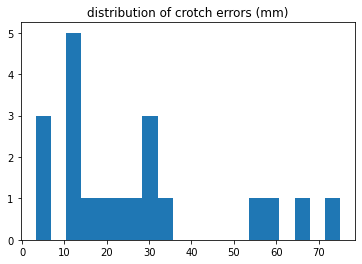

mean crotch error (mm): 26.83696668530059


In [62]:
crotch_errors = []
for fitted_lm, true_lm in zip(extracted_lm, tg3d_df['landmarks']):
    true_crotch = true_lm['surface']['crotch_point']
    fitted_crotch = fitted_lm[1]
    crotch_errors.append(np.linalg.norm(true_crotch-fitted_crotch))
plt.hist(crotch_errors, bins=20)
plt.title('distribution of crotch errors (mm)')
plt.show()
print('mean crotch error (mm):', np.mean(crotch_errors))

In [63]:
np.argsort(crotch_errors)

array([ 8, 19, 11, 12,  6,  0, 10, 14,  9,  3,  4,  7, 15, 18,  2, 17,  5,
        1, 16, 13])